In [23]:
import os
import json 
import requests
import pandas as pd

In [24]:
# Load sheet metadata from sources.json
with open("sources.json", "r") as f:
    sources = json.load(f)

# Container for DataFrames
all_dfs = []

In [25]:
# Loop through each source and load the data
for source in sources:
    sheet_id = source["sheet_id"]
    sheet_name = source["sheet_name"]
    name = source["name"]

    # Construct URL
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

    # Read CSV from the URL
    try:
        df = pd.read_csv(url)
        df['source'] = name  # Add a column to identify where it came from
        all_dfs.append(df)
        print(f"Successfully Loaded: {name}")
    except Exception as e:
        print(f"Failed to load data {name}: {e}")

# Concatenate all DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)

Successfully Loaded: Amin


In [26]:
combined_df.head()

,Food_Name,Province,Meal_Type,Website,Pictures_Website,is_approved,source
0,بریانی,Isfahan,Food,https://chishi.ir/2768-beryani-esfehan/,NaN,True,Amin
1,خورشت ماست,Isfahan,"Appetizer, Dessert",https://namnak.com/%D8%AE%D9%88%D8%B1%D8%B4-%D...,NaN,True,Amin
2,دوغ و گوشفیل,Isfahan,"Drinks, Appetizer",https://fa.wikipedia.org/wiki/%DA%AF%D9%88%D8%...,NaN,True,Amin
3,قیمه ریزه,Isfahan,Food,https://panamag.ir/616-gheyme-rize/,NaN,True,Amin
4,گز,Isfahan,"Appetizer, Dessert",https://namnak.com/%D8%B7%D8%B1%D8%B2-%D8%AA%D...,NaN,True,Amin


In [36]:
# Copy all records to df for manipulation
df = combined_df.copy()
df["id"] = combined_df.index + 1

# Normalize column names to avoid casing issues
df.columns = [col.strip().lower() for col in df.columns]
# Check for availability of is_approved and website columns
if "is_approved" not in df.columns or "website" not in df.columns:
    raise ValueError("Your DataFrame must contain 'is_approved' and 'website' columns.")

# To copy all the approved records in a seperate variable
approved_df = df[df["is_approved"] == True].copy()
approved_df

,food_name,province,meal_type,website,pictures_website,is_approved,source,id
0,بریانی,Isfahan,Food,https://chishi.ir/2768-beryani-esfehan/,NaN,True,Amin,1
1,خورشت ماست,Isfahan,"Appetizer, Dessert",https://namnak.com/%D8%AE%D9%88%D8%B1%D8%B4-%D...,NaN,True,Amin,2
2,دوغ و گوشفیل,Isfahan,"Drinks, Appetizer",https://fa.wikipedia.org/wiki/%DA%AF%D9%88%D8%...,NaN,True,Amin,3
3,قیمه ریزه,Isfahan,Food,https://panamag.ir/616-gheyme-rize/,NaN,True,Amin,4
4,گز,Isfahan,"Appetizer, Dessert",https://namnak.com/%D8%B7%D8%B1%D8%B2-%D8%AA%D...,NaN,True,Amin,5
5,پولکی,Isfahan,Dessert,https://namnak.com/%D9%BE%D9%88%D9%84%DA%A9%DB...,NaN,True,Amin,6
6,گوشت و لوبیا اصفهانی,Isfahan,Food,https://www.beytoote.com/cookery/ghazaha/pork1...,NaN,True,Amin,7
15,آبگوشت یخنی نخود,Fars,Food,https://chishi.ir/32587-abgousht-yakhni-nokhod/,NaN,True,Amin,16


In [37]:
# Make sure the 'foods' directory exists
os.makedirs("foods", exist_ok=True)

# Save the HTML content to a file named {id}.html inside 'foods' directory
def save_as_file(html_content, row_id):
    file_path = os.path.join("foods", f"{row_id}.html")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(html_content)

In [39]:

html_records = []

for _, row in approved_df.iterrows():
    site_url = row["website"]
    row_id = row.get("id")  # make sure your dataframe has an 'id' column
    print(row_id)

    try:
        response = requests.get(site_url, timeout=5)
        html_content = response.text
        print(f"(website)->{site_url} — HTML length: {len(html_content)}")

        save_as_file(html_content=html_content, row_id= row_id)
        
        html_records.append({
            "id": row_id,
            "html": html_content
        })

    except requests.RequestException as e:
        print(f"Failed to fetch {site_url}: {e}")


1
(website)->https://chishi.ir/2768-beryani-esfehan/ — HTML length: 87666
2
(website)->https://namnak.com/%D8%AE%D9%88%D8%B1%D8%B4-%D9%85%D8%A7%D8%B3%D8%AA-%D8%A7%D8%B5%D9%81%D9%87%D8%A7%D9%86%DB%8C.p14793 — HTML length: 117629
3
(website)->https://fa.wikipedia.org/wiki/%DA%AF%D9%88%D8%B4%E2%80%8C%D9%81%DB%8C%D9%84#:~:text=%D9%BE%DB%8C%D9%88%D9%86%D8%AF%20%D8%A8%D9%87%20%D8%A8%DB%8C%D8%B1%D9%88%D9%86-,%D8%AF%D9%88%D8%BA%20%D9%88%20%DA%AF%D9%88%D8%B4%D9%81%DB%8C%D9%84%20%D8%A7%D8%B5%D9%81%D9%87%D8%A7%D9%86,%D8%AA%D8%A7%20%D8%A8%D9%87%20%D8%A7%D9%85%D8%B1%D9%88%D8%B2%20%D8%A7%D8%AF%D8%A7%D9%85%D9%87%20%D8%AF%D8%A7%D8%B1%D8%AF. — HTML length: 131388
4
(website)->https://panamag.ir/616-gheyme-rize/ — HTML length: 61638
5
(website)->https://namnak.com/%D8%B7%D8%B1%D8%B2-%D8%AA%D9%87%DB%8C%D9%87-%DA%AF%D8%B2.p75656 — HTML length: 126306
6
(website)->https://namnak.com/%D9%BE%D9%88%D9%84%DA%A9%DB%8C-%DA%A9%D9%86%D8%AC%D8%AF%DB%8C.p15152 — HTML length: 108922
7
(website)->https://www.beytoote.

[{'id': 1,
  'html': '<!DOCTYPE html><html dir=rtl lang=fa-IR><head><script data-no-optimize="1">var litespeed_docref=sessionStorage.getItem("litespeed_docref");litespeed_docref&&(Object.defineProperty(document,"referrer",{get:function(){return litespeed_docref}}),sessionStorage.removeItem("litespeed_docref"));</script> <meta charset=UTF-8><link data-optimized="2" rel="stylesheet" href="https://chishi.ir/wp-content/litespeed/css/34a68f086c0103a565caf000a4f6f926.css?ver=6bcde" /><link rel="preload" as="image" href="https://chishi.ir/wp-content/themes/ProRM/images/logo.png"><link rel="preload" as="image" href="https://chishi.ir/wp-content/uploads/2020/06/beryani-esfehan.jpg"><title>طرز تهیه بریانی اصفهان خوشمزه و مخصوص به روش رستورانی</title><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="language" content="fa_IR" /><meta name="geo.region" content="IR" /><meta name="viewport" content="width=device-width, initial-scale=1"/><link rel="shortcut icon" type="image/ico" href="
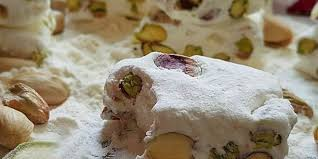

In [40]:
html_records